**Distil Installation**

In [1]:
!git clone https://github.com/decile-team/distil.git
!pip install apricot-select
%cd distil/examples/

Cloning into 'distil'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 375 (delta 173), reused 306 (delta 115), pack-reused 0
Receiving objects: 100% (375/375), 10.06 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (173/173), done.
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 163kB 19.8MB/s 
/content/distil/examples


**Imports**

In [4]:
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
sys.path.append('../')
from distil.active_learning_strategies import EntropySampling, BADGE,GLISTER
from distil.utils.models.mnist_net import MnistNet
from distil.utils.models.cifar10net import CifarNet
from distil.utils.models.resnet import ResNet18
from distil.utils.DataHandler import DataHandler_MNIST, DataHandler_CIFAR10
from distil.utils.dataset import get_dataset

**Training Class**

In [10]:
def init_weights(m):
    torch.manual_seed(42)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class data_train:

    def __init__(self, X, Y, net, handler, args):

        self.X = X
        self.Y = Y
        self.net = net
        self.handler = handler
        self.args = args
        self.n_pool = len(Y)
        self.use_cuda = torch.cuda.is_available()

    def update_index(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def update_data(self, X, Y):
    	self.X = X
    	self.Y = Y

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.

        for batch_id, (x, y, idxs) in enumerate(loader_tr):
            if self.use_cuda:
                x, y = Variable(x.cuda()), Variable(y.cuda())
            else:
                x, y = Variable(x), Variable(y)
            optimizer.zero_grad()
            out = self.clf(x)
            loss = F.cross_entropy(out, y)
            accFinal += torch.sum((torch.max(out,1)[1] == y).float()).data.item()
            loss.backward()

            # clamp gradients, just in case
            # for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

            optimizer.step()
        return accFinal / len(loader_tr.dataset.X)

    
    def train(self):

        # print('Training..')
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        n_epoch = self.args['n_epoch']
        if self.use_cuda:
            self.clf =  self.net.apply(weight_reset).cuda()
        else:
            self.clf =  self.net.apply(weight_reset)

        optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)
        loader_tr = DataLoader(self.handler(self.X, self.Y, False), shuffle=True, batch_size = args['batch_size'])
        epoch = 1
        accCurrent = 0
        while accCurrent < 0.99 and epoch < n_epoch: 
            accCurrent = self._train(epoch, loader_tr, optimizer)
            epoch += 1
            # print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)
            
            if (epoch % 50 == 0) and (accCurrent < 0.2): # resetif not converging
                self.clf = self.net.apply(weight_reset)
                optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        print('Epoch:', str(epoch),'Training accuracy:',round(accCurrent*100, 2), flush=True)
        return self.clf

**Data & Model Configuration**

In [23]:
data_set_name = 'CIFAR10'
download_path = '../downloaded_data/'
X, y, X_test, y_test = get_dataset(data_set_name, download_path)
dim = np.shape(X)[1:]
handler = DataHandler_CIFAR10

X_tr = X[:5000]
y_tr = y[:5000]
X_unlabeled = X[5000:]
y_unlabeled = y[5000:]

X_test = X_test
y_test = y_test.numpy()

nclasses = 10
n_rounds = 10    ##Number of rounds to run active learning
budget = 1000 

net = ResNet18()
net.apply(init_weights)

Files already downloaded and verified
Files already downloaded and verified


**UNCERTAINITY SAMPLING**

In [46]:
#Initializing Strategy Class
strategy_args = {'batch_size' : 1000}
strategy = EntropySampling(X_tr, y_tr, X_unlabeled, net, handler, nclasses, strategy_args)

#Initial Training
args = {'n_epoch':150, 'lr':float(0.001), 'batch_size':128} 
dt = data_train(X_tr, y_tr, net, handler, args)
clf = dt.train()

#Updating the trained model in strategy class
strategy.update_model(clf)

y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = (1.0*(y_test == y_pred)).sum().item() / len(y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    #Using select function for getting next set of data points
    idx = strategy.select(budget)

    #Saving state of model, since labeling new points might take time
    strategy.save_state()

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state()
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(X_test).numpy()
    acc[rd] = round((1.0*(y_test == y_pred)).sum().item() / len(y_test), 3)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break

print('Training Completed')

#Saving accuracies for further analysis
with open('/content/entropy.txt', 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Epoch: 21 Training accuracy: 99.42
Initial Testing accuracy: 62.95
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 6000
Epoch: 18 Training accuracy: 99.03
Testing accuracy: 61.2
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Epoch: 17 Training accuracy: 99.14
Testing accuracy: 62.2
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 8000
Epoch: 17 Training accuracy: 99.25
Testing accuracy: 64.7
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 9000
Epoch: 16 Training accuracy: 99.47
Testing accuracy: 67.1
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points - 1

**BADGE SAMPLING**

In [6]:
strategy_args = {'batch_size' : 1000}
strategy = BADGE(X_tr, y_tr, X_unlabeled, net, handler, nclasses, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001), 'batch_size':128} 
dt = data_train(X_tr, y_tr, net, handler, args)
clf = dt.train()
strategy.update_model(clf)
y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = (1.0*(y_test == y_pred)).sum().item() / len(y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')
    idx = strategy.select(budget)
    strategy.save_state()

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state()
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(X_test).numpy()
    acc[rd] = round((1.0*(y_test == y_pred)).sum().item() / len(y_test), 3)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break
        
print('Training Completed')
with open('/content/badge.txt', 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Epoch: 21 Training accuracy: 99.08
Initial Testing accuracy: 62.8
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 6000
Epoch: 17 Training accuracy: 99.18
Testing accuracy: 61.4
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Epoch: 25 Training accuracy: 99.3
Testing accuracy: 65.9
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 8000
Epoch: 17 Training accuracy: 99.22
Testing accuracy: 65.4
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 9000
Epoch: 15 Training accuracy: 99.31
Testing accuracy: 66.9
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points - 100

**GLISTER-ACTIVE**

In [39]:
import warnings
warnings.filterwarnings("ignore")
strategy_args = {'batch_size' : 1000, 'lr':float(0.001)}
strategy = GLISTER(X_tr, y_tr, X_unlabeled, net, handler, nclasses, strategy_args,valid=False, typeOf='rand', lam=0.1)

args = {'n_epoch':150, 'lr':float(0.001), 'batch_size':128} 
dt = data_train(X_tr, y_tr, net, handler, args)
clf = dt.train()
strategy.update_model(clf)
y_pred = strategy.predict(X_test).numpy()
acc = np.zeros(n_rounds)
acc[0] = (1.0*(y_test == y_pred)).sum().item() / len(y_test)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

##User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')
    idx = strategy.select(budget)
    strategy.save_state()

    #Adding new points to training set
    X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
    X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

    #Human In Loop, Assuming user adds new labels here
    y_tr = np.concatenate((y_tr, y_unlabeled[idx]), axis = 0)
    y_unlabeled = np.delete(y_unlabeled, idx, axis = 0)
    print('Number of training points -',X_tr.shape[0])

    #Reload state and start training
    strategy.load_state()
    strategy.update_data(X_tr, y_tr, X_unlabeled)
    dt.update_data(X_tr, y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(X_test).numpy()
    acc[rd] = round((1.0*(y_test == y_pred)).sum().item() / len(y_test), 3)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)
    if acc[rd] > 0.98:
        print('Testing accuracy reached above 98%, stopping training!')
        break
        
print('Training Completed')
with open('/content/glister.txt', 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Epoch: 24 Training accuracy: 99.18
Initial Testing accuracy: 62.94
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 6000
Epoch: 20 Training accuracy: 99.13
Testing accuracy: 63.7
-------------------------------------------------
Round 2
-------------------------------------------------
Number of training points - 7000
Epoch: 18 Training accuracy: 99.31
Testing accuracy: 63.9
-------------------------------------------------
Round 3
-------------------------------------------------
Number of training points - 8000
Epoch: 16 Training accuracy: 99.1
Testing accuracy: 64.1
-------------------------------------------------
Round 4
-------------------------------------------------
Number of training points - 9000
Epoch: 19 Training accuracy: 99.31
Testing accuracy: 67.1
-------------------------------------------------
Round 5
-------------------------------------------------
Number of training points - 10

**VISUALISATION**

Text(0.5, 1.0, 'DISTIL_CIFAR10')

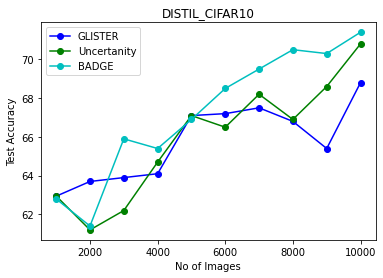

In [22]:
#Loading accuracies
with open('/content/entropy.txt') as f:
  acc_ = f.readlines()
acc_en = [round(float(x)*100, 2) for x in acc_]
with open('/content/badge.txt') as f:
  acc_ = f.readlines()
acc_bd = [round(float(x)*100, 2) for x in acc_]
with open('/content/glister.txt') as f:
  acc_ = f.readlines()
acc_gl = [round(float(x)*100, 2) for x in acc_]

#Plotting
import matplotlib.pyplot as plt
n_rounds = 9
x_axis = np.array([budget for i in range(n_rounds+1)])
x_axis = x_axis*np.array([i for i in range(1,n_rounds+2)])
plt.figure()
plt.plot(x_axis, acc_gl, 'b-', label='GLISTER',marker='o')
plt.plot(x_axis, acc_en, 'g-', label='Uncertanity',marker='o')
plt.plot(x_axis, acc_bd, 'c', label='BADGE',marker='o')


plt.legend()
plt.xlabel('No of Images')
plt.ylabel('Test Accuracy')
plt.title('DISTIL_CIFAR10')